# SetUp

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection")

In [ ]:
%reset-f

In [ ]:
!pip install easyocr

In [ ]:
import easyocr

import torch
from torch import nn
# import torch.optim as optim
# from torch.autograd import Variable
# import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os
# import random

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available() : print(torch.cuda.get_device_name(0))

import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import PIL

In [ ]:
reader = easyocr.Reader(['hi'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


# Required Functions

In [ ]:
# Hindi Unicode Hex Range is 2304:2435
pad_char = '<pad>'
hindi_alphabets_dict = { pad_char:0, '<sos>':1, '<eos>':2 }
for num in range(2304, 2436) :
    hindi_alphabets_dict[chr(num)] = num - 2301
# print(hindi_alphabets_dict)
# print(len(hindi_alphabets_dict))

english_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '<pad>'
english_alphabets_dict = { pad_char:0, '<sos>':1, '<eos>':2 }
for index, alphabet in enumerate(english_alphabets) :
    english_alphabets_dict[alphabet] = index + 3
# print(english_alphabets_dict)
# print(len(english_alphabets_dict))

english_reverse_dict = {}
for keys in english_alphabets_dict :
    english_reverse_dict[english_alphabets_dict[keys]] = keys
# print(english_reverse_dict)

In [ ]:
def return_cleaned_text(word, language) :
    final_word = ''
    word = word.upper()
    if language == 'eng' :
        for letter in word :
            if letter in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' : final_word += letter
    else :
        for letter in word :
            if letter in 'ऀँंःऄअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसहऺऻ़ऽािीुूृॄॅॆेैॉॊोौ्ॎॏॐ॒॑॓॔ॕॖॗक़ख़ग़ज़ड़ढ़फ़य़ॠॡॢॣ०१२३४५६७८९॰ॱॲॳॴॵॶॷॸॹॺॻॼॽॾॿঀঁংঃ' : final_word += letter
    return final_word

def output_english_word (hindi_word, hindi_dict, english_dict, model, max_output_length=16, device=device, verbose=False, return_vector=False) :
    predictions = [1]
    english_word = ''
    hindi_word = return_cleaned_text(hindi_word, language='hin')[:14]
    hindi_word_vector = np.array([1] + [0]*len(hindi_word) + [2] + [0]*(14-len(hindi_word)))
    for i, letter in enumerate(hindi_word) : hindi_word_vector[i+1] = hindi_dict[letter]
    hindi_word_vector = torch.tensor(np.array(hindi_word_vector).reshape(1,-1))
    for i in range(max_output_length) :
        input_tensor = torch.tensor(predictions).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(hindi_word_vector.to(device), input_tensor.to(device))
        word_index = out.argmax(dim=-1)[:, -1].item()
        predictions.append(word_index)
        if word_index == 2 : break
        else : english_word += english_dict[word_index]
    if verbose : print(hindi_word, ' ------> ', english_word)
    if return_vector : return predictions
    else : return english_word

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert self.head_dim * heads == embed_size, "Embed size needs to be divisible by the number of heads"
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(self.heads * self.head_dim, embed_size)
    def forward(self, keys, values, queries, mask=None):
        N = queries.shape[0]
        key_len, value_len, query_len = keys.shape[1], values.shape[1], queries.shape[1]
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        keys = self.keys(keys)
        values = self.values(values)
        queries = self.queries(queries)
        energy = torch.einsum("nqhd,nkhd->nhqk", queries, keys)
        if mask is not None : energy = energy.masked_fill(mask == 0, float("-1e20"))
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", attention, values).reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)
        return out

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention_layer = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential   (
                                            nn.Linear(embed_size, forward_expansion * embed_size), nn.ReLU(),
                                            nn.Linear(forward_expansion * embed_size, embed_size),
                                            )
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)
    def forward(self, keys, values, queries, mask):
        attention = self.attention_layer(keys, values, queries, mask)
        x = self.dropout(self.norm1(attention + queries))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_len, device):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.positional_embedding = nn.Embedding(max_len, embed_size)
        self.layers = nn.ModuleList([TransformerBlock(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, mask):
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        x = torch.tensor(x, dtype=int).clone().detach()
        out = self.dropout(self.word_embedding(x) + self.positional_embedding(positions))
        for layer in self.layers : out = layer(out, out, out, mask)
        return out

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout):
        super(DecoderBlock, self).__init__()
        self.attention_layer = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, keys, values, src_mask, trg_mask):
        attention = self.attention_layer.forward(x, x, x, trg_mask)
        queries = self.dropout(self.norm(attention + x))
        out = self.transformer_block(keys, values, queries, src_mask)
        return out
class Decoder(nn.Module):
    def __init__(self, trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_len, device):
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.positional_embedding = nn.Embedding(max_len, embed_size)
        self.layers = nn.ModuleList( [ DecoderBlock(embed_size, heads, forward_expansion, dropout) for _ in range(num_layers) ] )
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        x = torch.tensor(x, dtype=int).clone().detach()
        out = self.dropout(self.word_embedding(x) + self.positional_embedding(positions))
        for layer in self.layers : out = layer(out, enc_out, enc_out, src_mask, trg_mask)
        out = self.fc_out(out)
        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, embed_size=256, num_layers=6, forward_expansion=4, heads=8, dropout=0, device=device, max_len=100):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size,  embed_size,  num_layers,  heads,  forward_expansion,  dropout, max_len, device)
        self.decoder = Decoder(trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_len, device)
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2) # (N, 1, 1, src_len)
        return src_mask.to(self.device)
    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones(trg_len, trg_len)).expand(N, 1, trg_len, trg_len)
        return trg_mask.to(self.device)
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_out, src_mask, trg_mask)
        return out

In [ ]:
def get_model (model_path, src_vocab_size=len(hindi_alphabets_dict), trg_vocab_size=len(english_alphabets_dict), device=device) :
    if torch.cuda.is_available() :
        model_weights = torch.load(model_path)
    else :
        model_weights = torch.load(model_path, map_location=torch.device('cpu'))
    model = Transformer(src_vocab_size, trg_vocab_size, 0, 0, device=device).to(device)
    model.load_state_dict(model_weights)
    return model

In [ ]:
def add_right_padding_and_text (cv2_image, text_in_image, text_color, right_padding=None, padding_color='black') :
    pil_img = Image.fromarray(cv2_image)
    width, height = pil_img.size
    if right_padding is None : new_width = width *4
    else : new_width = width + right_padding
    new_height = height
    result = Image.new(pil_img.mode, (new_width, new_height), padding_color)
    result.paste(pil_img, (0, 0))
    image = np.asarray(result)

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    thickness = 2

    for i, line in enumerate(text_in_image) :
        org = (width + 10 , (50*i) + 50)
        image = cv2.putText(image, line, org, font, fontScale, text_color, thickness, cv2.LINE_AA)
    return image

def detect_and_predict (image_path, model, hindi_alphabets_dict=hindi_alphabets_dict, english_reverse_dict=english_reverse_dict,
                        box_colour=(255,255,0), print_text_colour=(0, 0, 255), print_image=True, print_text_in_image=True, verbose=False) :

    text_shift = [-10,10]
    circle_shift = [10,-10]
    fontScale = 1
    thickness = 2
    bottomLeftOrigin=cv2.LINE_AA
    radius = 16
    font = cv2.FONT_HERSHEY_SIMPLEX
    all_text_in_image = []

    image = cv2.imread(image_path)
    predicted = reader.readtext(image, detail=1)
    counter = 0
    for pred in predicted :
        cordinates, hindi_word, prob = pred
        if prob > 0.5 :

            if ' ' in hindi_word :
                transliterated_prediction = ''
                for word in hindi_word.split() : transliterated_prediction += output_english_word(word, hindi_alphabets_dict, english_reverse_dict, model) + ' '
            else : transliterated_prediction = output_english_word(hindi_word, hindi_alphabets_dict, english_reverse_dict, model)

            LeftTop, RightTop, RightBottom, LeftBottom = cordinates
            LeftTop = list([int(LeftTop[0]), int(LeftTop[1])])
            RightTop = list([int(RightTop[0]), int(RightTop[1])])
            RightBottom = list([int(RightBottom[0]), int(RightBottom[1])])
            LeftBottom = list([int(LeftBottom[0]), int(LeftBottom[1])])

            counter += 1
            text = str(counter)
            org = list((np.array(RightTop) + np.array(text_shift)))
            circle_org = list(np.array(org) + np.array(circle_shift))

            image = cv2.putText(image, text, org, font, fontScale, box_colour, thickness, bottomLeftOrigin)
            image = cv2.circle(image, center=circle_org, radius=radius, color=box_colour, thickness=thickness)
            image = cv2.line(image, LeftTop, [RightTop[0]-int(radius), RightTop[1]], color=box_colour, thickness=3)
            image = cv2.line(image, [RightTop[0], RightTop[1]+radius], RightBottom, color=box_colour, thickness=3)
            image = cv2.line(image, RightBottom, LeftBottom, color=box_colour, thickness=3)
            image = cv2.line(image, LeftBottom, LeftTop, color=box_colour, thickness=3)
            all_text_in_image.append(str(counter) + ' -----> ' + str(transliterated_prediction))

            if verbose : print(counter, ' -----> ', hindi_word, ' : ', transliterated_prediction) # Hindi Word : # Transliterated Word :

    if print_text_in_image : image = add_right_padding_and_text(image, all_text_in_image, print_text_colour)
    if print_image : cv2_imshow(image)
    return image, all_text_in_image

# Predictions

In [ ]:
model_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Models - CheckPoints/Transliteration/Transliteration - Final Model to Save (num_samples = 14880).pt'
model = get_model(model_path)

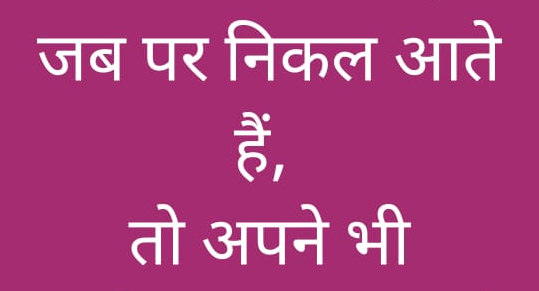

In [ ]:
image_name = '8.png'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name

image = cv2.imread(img_path)
cv2_imshow(image)

1  ----->  जब पर निकल आते  :  JAB PAR NIKAL ATE 
2  ----->  हैं,  :  HAI
3  ----->  तो अपने भी  :  TO APANE BHII 


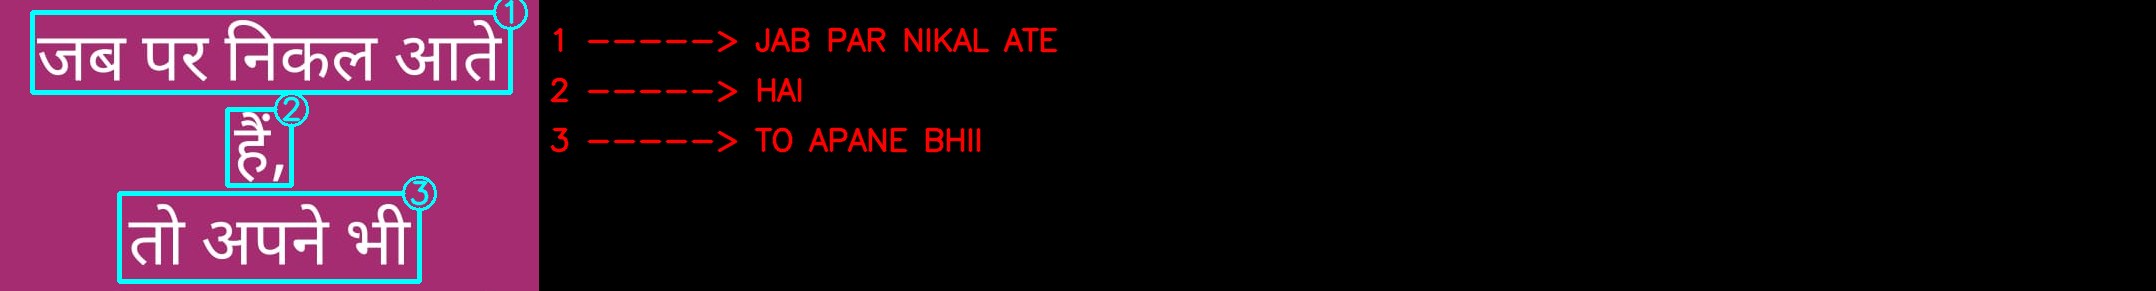

In [ ]:
image_name = '8.png'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True);

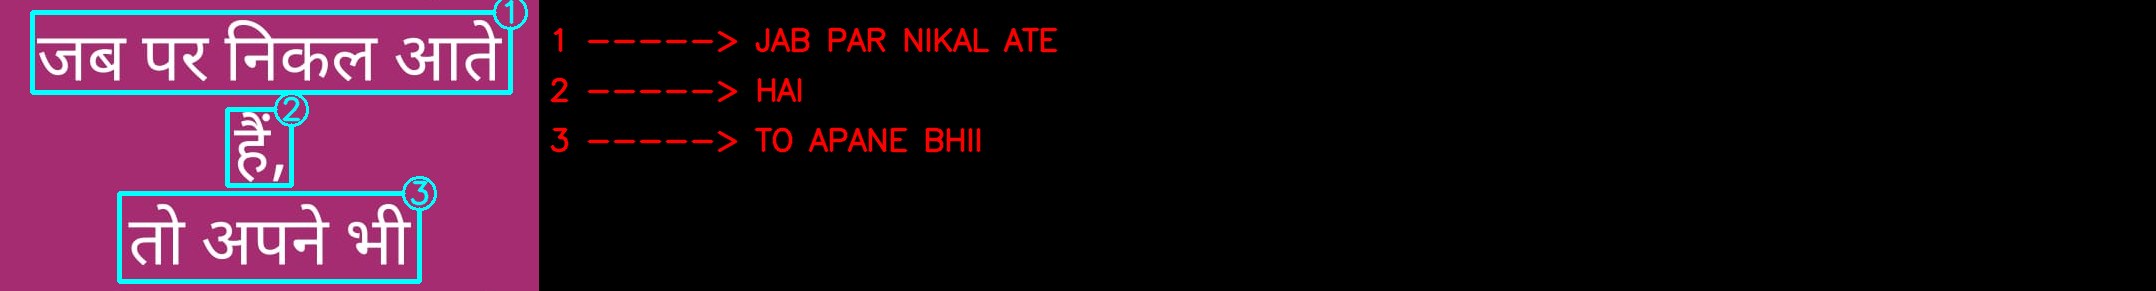

In [ ]:
image_name = '8.png'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
detect_and_predict(img_path, model);

In [ ]:
image_name = '8.png'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
detect_and_predict(img_path, model, print_image=False, verbose=True);

1  ----->  जब पर निकल आते  :  JAB PAR NIKAL ATE 
2  ----->  हैं,  :  HAI
3  ----->  तो अपने भी  :  TO APANE BHII 


1  ----->  जब पर निकल आते  :  JAB PAR NIKAL ATE 
2  ----->  हैं,  :  HAI
3  ----->  तो अपने भी  :  TO APANE BHII 


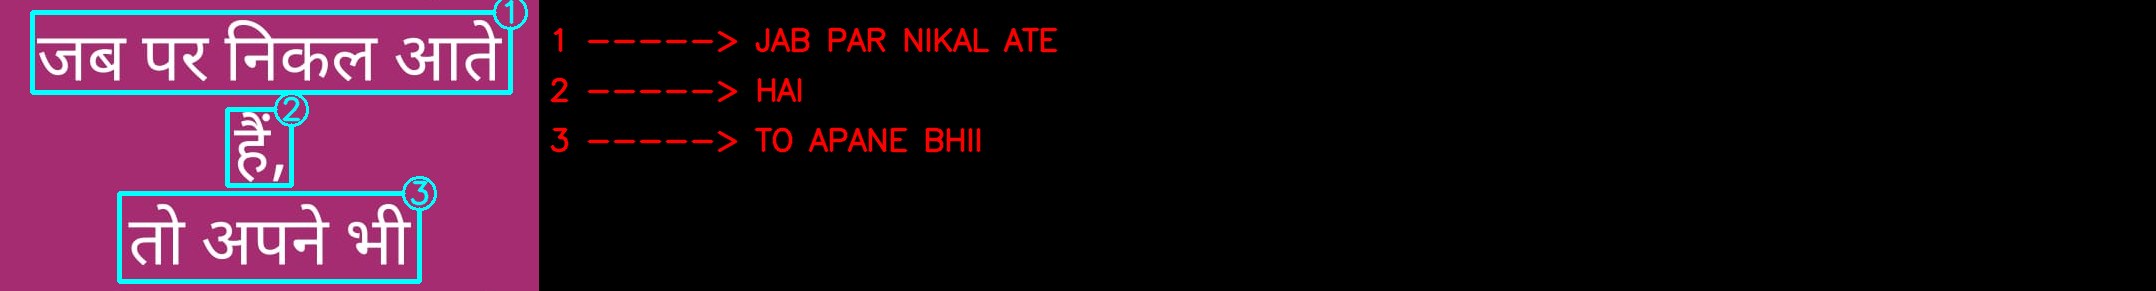

In [ ]:
image_name = '8.png'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
detect_and_predict(img_path, model, print_image=True, verbose=True);

In [ ]:
image_name = 'Test.jpg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

KeyboardInterrupt: ignored

In [ ]:
image_name = 'Test - 2.jpg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = 'Test - 3.jpg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = 'Test - 4.jpg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = 'Test - 5.jpg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = 'Test - 6.jpg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = 'Test - 7.jpg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = 'Test - 8.jpg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = 'Test - 9.jpg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = 'Test - 10.jpg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = '1.jpeg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = '2.jpeg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = '2-dup.jpeg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = '3.jpeg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = '4.jpeg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = '5.jpeg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = '6.jpeg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = '7.jpeg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = '8.png'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

In [ ]:
image_name = '9.jpeg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
temp_img, _ = detect_and_predict(img_path, model, print_image=True, verbose=True)

# Final Class

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection")

In [ ]:
# %reset-f

In [ ]:
!pip install easyocr

     |████████████████████████████████| 63.6 MB 57 kB/s 
     |████████████████████████████████| 47.6 MB 1.6 MB/s 


In [ ]:
import easyocr

import torch
from torch import nn

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available() : print(torch.cuda.get_device_name(0))

import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image
import PIL

In [ ]:
# reader = easyocr.Reader(['hi'])

# Required Functions

In [ ]:
# # Hindi Unicode Hex Range is 2304:2435
# pad_char = '<pad>'
# hindi_alphabets_dict = { pad_char:0, '<sos>':1, '<eos>':2 }
# for num in range(2304, 2436) :
#     hindi_alphabets_dict[chr(num)] = num - 2301
# # print(hindi_alphabets_dict)
# # print(len(hindi_alphabets_dict))

# english_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
# pad_char = '<pad>'
# english_alphabets_dict = { pad_char:0, '<sos>':1, '<eos>':2 }
# for index, alphabet in enumerate(english_alphabets) :
#     english_alphabets_dict[alphabet] = index + 3
# # print(english_alphabets_dict)
# # print(len(english_alphabets_dict))

# english_reverse_dict = {}
# for keys in english_alphabets_dict :
#     english_reverse_dict[english_alphabets_dict[keys]] = keys
# # print(english_reverse_dict)

In [ ]:
def return_cleaned_text(word, language) :
    final_word = ''
    word = word.upper()
    if language == 'eng' :
        for letter in word :
            if letter in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' : final_word += letter
    else :
        for letter in word :
            if letter in 'ऀँंःऄअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसहऺऻ़ऽािीुूृॄॅॆेैॉॊोौ्ॎॏॐ॒॑॓॔ॕॖॗक़ख़ग़ज़ड़ढ़फ़य़ॠॡॢॣ०१२३४५६७८९॰ॱॲॳॴॵॶॷॸॹॺॻॼॽॾॿঀঁংঃ' : final_word += letter
    return final_word

def output_english_word (hindi_word, hindi_dict, english_dict, model, max_output_length=16, device=device, verbose=False, return_vector=False) :
    predictions = [1]
    english_word = ''
    hindi_word = return_cleaned_text(hindi_word, language='hin')[:14]
    hindi_word_vector = np.array([1] + [0]*len(hindi_word) + [2] + [0]*(14-len(hindi_word)))
    for i, letter in enumerate(hindi_word) : hindi_word_vector[i+1] = hindi_dict[letter]
    hindi_word_vector = torch.tensor(np.array(hindi_word_vector).reshape(1,-1))
    for i in range(max_output_length) :
        input_tensor = torch.tensor(predictions).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(hindi_word_vector.to(device), input_tensor.to(device))
        word_index = out.argmax(dim=-1)[:, -1].item()
        predictions.append(word_index)
        if word_index == 2 : break
        else : english_word += english_dict[word_index]
    if verbose : print(hindi_word, ' ------> ', english_word)
    if return_vector : return predictions
    else : return english_word

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert self.head_dim * heads == embed_size, "Embed size needs to be divisible by the number of heads"
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(self.heads * self.head_dim, embed_size)
    def forward(self, keys, values, queries, mask=None):
        N = queries.shape[0]
        key_len, value_len, query_len = keys.shape[1], values.shape[1], queries.shape[1]
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        keys = self.keys(keys)
        values = self.values(values)
        queries = self.queries(queries)
        energy = torch.einsum("nqhd,nkhd->nhqk", queries, keys)
        if mask is not None : energy = energy.masked_fill(mask == 0, float("-1e20"))
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        out = torch.einsum("nhql,nlhd->nqhd", attention, values).reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)
        return out

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention_layer = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.feed_forward = nn.Sequential   (
                                            nn.Linear(embed_size, forward_expansion * embed_size), nn.ReLU(),
                                            nn.Linear(forward_expansion * embed_size, embed_size),
                                            )
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)
    def forward(self, keys, values, queries, mask):
        attention = self.attention_layer(keys, values, queries, mask)
        x = self.dropout(self.norm1(attention + queries))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Encoder(nn.Module):
    def __init__(self, src_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_len, device):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.positional_embedding = nn.Embedding(max_len, embed_size)
        self.layers = nn.ModuleList([TransformerBlock(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, mask):
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        x = torch.tensor(x, dtype=int).clone().detach()
        out = self.dropout(self.word_embedding(x) + self.positional_embedding(positions))
        for layer in self.layers : out = layer(out, out, out, mask)
        return out

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout):
        super(DecoderBlock, self).__init__()
        self.attention_layer = SelfAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, keys, values, src_mask, trg_mask):
        attention = self.attention_layer.forward(x, x, x, trg_mask)
        queries = self.dropout(self.norm(attention + x))
        out = self.transformer_block(keys, values, queries, src_mask)
        return out
class Decoder(nn.Module):
    def __init__(self, trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_len, device):
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.device = device
        self.word_embedding = nn.Embedding(trg_vocab_size, embed_size)
        self.positional_embedding = nn.Embedding(max_len, embed_size)
        self.layers = nn.ModuleList( [ DecoderBlock(embed_size, heads, forward_expansion, dropout) for _ in range(num_layers) ] )
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(embed_size, trg_vocab_size)
    def forward(self, x, enc_out, src_mask, trg_mask):
        N, seq_len = x.shape
        positions = torch.arange(0, seq_len).expand(N, seq_len).to(self.device)
        x = torch.tensor(x, dtype=int).clone().detach()
        out = self.dropout(self.word_embedding(x) + self.positional_embedding(positions))
        for layer in self.layers : out = layer(out, enc_out, enc_out, src_mask, trg_mask)
        out = self.fc_out(out)
        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, embed_size=256, num_layers=6, forward_expansion=4, heads=8, dropout=0, device=device, max_len=100):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size,  embed_size,  num_layers,  heads,  forward_expansion,  dropout, max_len, device)
        self.decoder = Decoder(trg_vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_len, device)
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2) # (N, 1, 1, src_len)
        return src_mask.to(self.device)
    def make_trg_mask(self, trg):
        N, trg_len = trg.shape
        trg_mask = torch.tril(torch.ones(trg_len, trg_len)).expand(N, 1, trg_len, trg_len)
        return trg_mask.to(self.device)
    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src, src_mask)
        out = self.decoder(trg, enc_out, src_mask, trg_mask)
        return out

In [ ]:
# def get_model (model_path, src_vocab_size=len(hindi_alphabets_dict), trg_vocab_size=len(english_alphabets_dict), device=device) :
#     if torch.cuda.is_available() :
#         model_weights = torch.load(model_path)
#     else :
#         model_weights = torch.load(model_path, map_location=torch.device('cpu'))
#     model = Transformer(src_vocab_size, trg_vocab_size, 0, 0, device=device).to(device)
#     model.load_state_dict(model_weights)
#     return model

In [ ]:
def add_right_padding_and_text (cv2_image, text_in_image, text_color, right_padding_factor=3, padding_color='black') :
    pil_img = Image.fromarray(cv2_image)
    width, height = pil_img.size
    new_width = int(width * right_padding_factor)
    new_height = height
    result = Image.new(pil_img.mode, (new_width, new_height), padding_color)
    result.paste(pil_img, (0, 0))
    image = np.asarray(result)

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    thickness = 2

    for i, line in enumerate(text_in_image) : image = cv2.putText(image, line, (width+10,(50*i)+50), font, fontScale, text_color, thickness, cv2.LINE_AA)
    return image

def detect_and_predict (image_path, model, hindi_alphabets_dict, english_reverse_dict, box_colour=(255,255,0), print_text_colour=(0, 0, 255),
                        print_image=True, print_text_in_image=True, detailed_text=False, right_padding_factor=3, verbose=False) :

    text_shift = [-10,10]
    circle_shift = [10,-10]
    fontScale = 1
    thickness = 2
    bottomLeftOrigin=cv2.LINE_AA
    radius = 16
    font = cv2.FONT_HERSHEY_SIMPLEX
    all_text_in_image = []
    all_detailed_text = ''

    image = cv2.imread(image_path)
    reader = easyocr.Reader(['hi'])
    predicted = reader.readtext(image, detail=1)
    counter = 0
    for pred in predicted :
        cordinates, hindi_word, prob = pred
        if prob > 0.5 :

            if ' ' in hindi_word :
                transliterated_prediction = ''
                for word in hindi_word.split() : transliterated_prediction += output_english_word(word, hindi_alphabets_dict, english_reverse_dict, model) + ' '
            else : transliterated_prediction = output_english_word(hindi_word, hindi_alphabets_dict, english_reverse_dict, model)

            LeftTop, RightTop, RightBottom, LeftBottom = cordinates
            LeftTop = list([int(LeftTop[0]), int(LeftTop[1])])
            RightTop = list([int(RightTop[0]), int(RightTop[1])])
            RightBottom = list([int(RightBottom[0]), int(RightBottom[1])])
            LeftBottom = list([int(LeftBottom[0]), int(LeftBottom[1])])

            counter += 1
            text = str(counter)
            org = list((np.array(RightTop) + np.array(text_shift)))
            circle_org = list(np.array(org) + np.array(circle_shift))

            image = cv2.putText(image, text, org, font, fontScale, box_colour, thickness, bottomLeftOrigin)
            image = cv2.circle(image, center=circle_org, radius=radius, color=box_colour, thickness=thickness)
            image = cv2.line(image, LeftTop, [RightTop[0]-int(radius), RightTop[1]], color=box_colour, thickness=3)
            image = cv2.line(image, [RightTop[0], RightTop[1]+radius], RightBottom, color=box_colour, thickness=3)
            image = cv2.line(image, RightBottom, LeftBottom, color=box_colour, thickness=3)
            image = cv2.line(image, LeftBottom, LeftTop, color=box_colour, thickness=3)
            all_text_in_image.append(str(counter) + ' -----> ' + str(transliterated_prediction))

            if verbose : print(counter, ' -----> ', hindi_word, ' : ', transliterated_prediction) # Hindi Word : # Transliterated Word :
            if detailed_text : all_detailed_text += str(str(counter)+' -----> '+str(hindi_word)+' : '+str(transliterated_prediction)+'\n')

    if print_text_in_image : image = add_right_padding_and_text(image, all_text_in_image, print_text_colour, right_padding_factor)
    if print_image : cv2_imshow(image)
    if detailed_text : return image, all_text_in_image, all_detailed_text
    return image, all_text_in_image, None

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


1 -----> जब पर निकल आते : JAB PAR NIKAL ATE 
2 -----> हैं, : HAI
3 -----> तो अपने भी : TO APANE BHII 



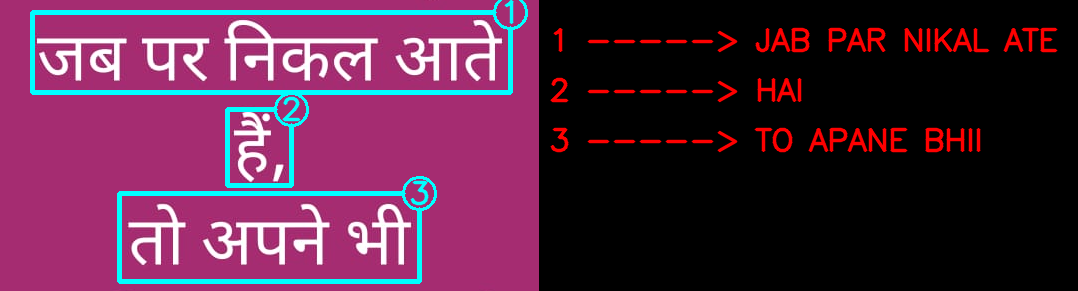

In [ ]:
class Transliterate (nn.Module) :

    def __init__ (self, model_path, print_image=False, print_text_in_image=True, verbose=False, detailed_text=False, right_padding_factor=2, device=device) :
        super(Transliterate, self).__init__()
        self.device = device
        self.hindi_alphabets_dict, self.english_alphabets_dict, self.english_reverse_dict = self.get_dictionaries()
        self.model = self.get_model(model_path, src_vocab_size=len(self.hindi_alphabets_dict), trg_vocab_size=len(self.english_alphabets_dict), device=self.device)
        self.print_image, self.print_text_in_image, self.verbose, self.detailed_text, self.right_padding_factor = print_image, print_text_in_image, verbose, detailed_text, right_padding_factor

    def get_dictionaries (self) :
        pad_char, english_alphabets = '<pad>', 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
        hindi_alphabets_dict, english_alphabets_dict, english_reverse_dict = { pad_char:0, '<sos>':1, '<eos>':2 }, { pad_char:0, '<sos>':1, '<eos>':2 }, {}
        # Hindi Dictionary
        for num in range(2304, 2436) : hindi_alphabets_dict[chr(num)] = num - 2301
        # English Dictionay
        for index, alphabet in enumerate(english_alphabets) : english_alphabets_dict[alphabet] = index + 3
        # English Reverse Dictionary
        for keys in english_alphabets_dict : english_reverse_dict[english_alphabets_dict[keys]] = keys
        return hindi_alphabets_dict, english_alphabets_dict, english_reverse_dict

    def get_model (self, model_path, src_vocab_size, trg_vocab_size, device) :
        if torch.cuda.is_available() : model_weights = torch.load(model_path)
        else : model_weights = torch.load(model_path, map_location=torch.device('cpu'))
        model = Transformer(src_vocab_size, trg_vocab_size, 0, 0, device=device).to(device)
        model.load_state_dict(model_weights)
        return model

    def forward (self, image_path) :
        pred_img, pred_text, detailed_text = detect_and_predict (image_path, self.model, self.hindi_alphabets_dict, self.english_reverse_dict, box_colour=(255,255,0),
                                                  print_text_colour=(0, 0, 255), print_image=self.print_image, print_text_in_image=self.print_text_in_image,
                                                  detailed_text=self.detailed_text, right_padding_factor=self.right_padding_factor, verbose=self.verbose)
        return pred_img, pred_text, detailed_text



image_name = '8.png'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name
model_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Models - CheckPoints/Transliteration/Transliteration - Final Model to Save (num_samples = 14880).pt'

obj1 = Transliterate(model_path, detailed_text=True, right_padding_factor=2)
img, text, detailed_text = obj1(img_path)
print(detailed_text)
cv2_imshow(img)

# Predict

In [ ]:
model_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Models - CheckPoints/Transliteration/Transliteration - Final Model to Save (num_samples = 14880).pt'

transliterate = Transliterate(model_path)

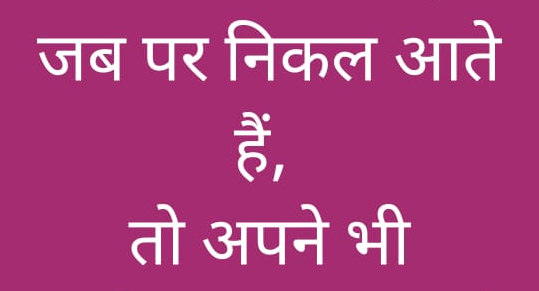

In [ ]:
image_name = '8.png'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name

image = cv2.imread(img_path)
cv2_imshow(image)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


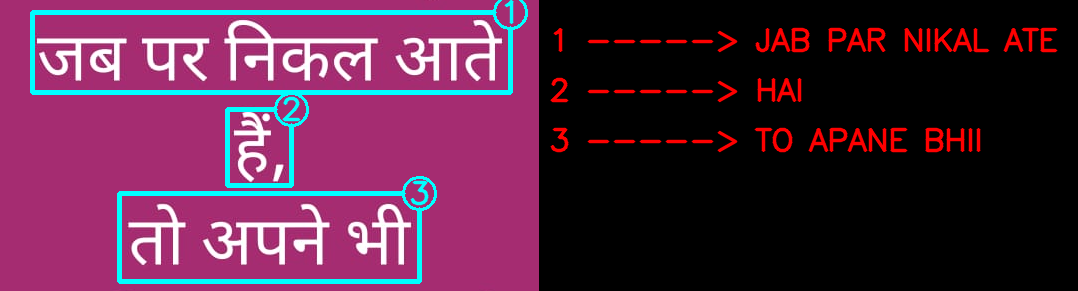

In [ ]:
image_name = '8.png'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name

img, text, detailed_text = transliterate(img_path)
cv2_imshow(img)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


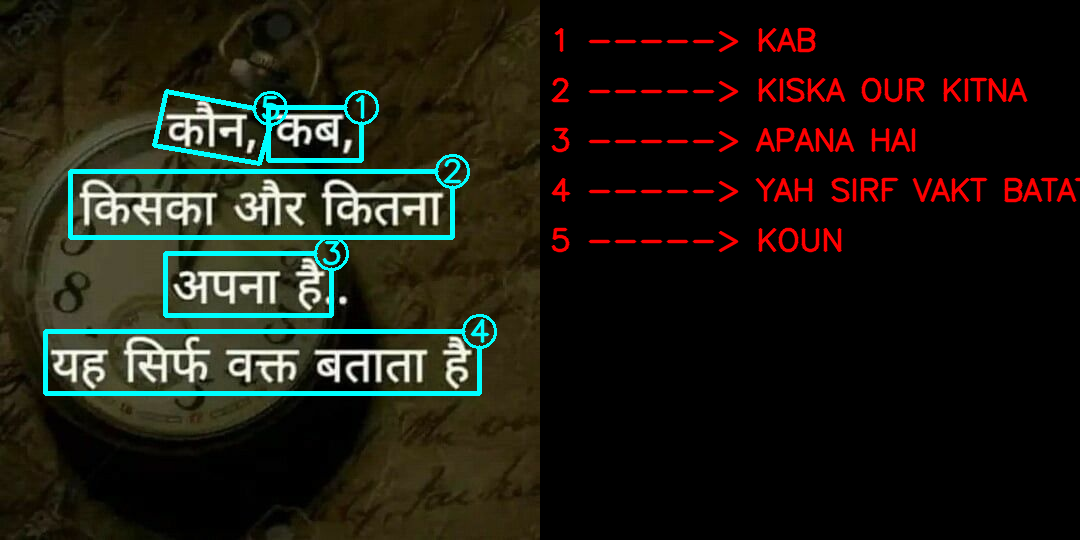

In [ ]:
image_name = 'Test.jpg'
img_path = '/content/gdrive/My Drive/Colab Notebooks/5) Deep Learning/Projects/Common/Sign Board Text Detection/Temp Images/' + image_name

img, text, detailed_text = transliterate(img_path)
cv2_imshow(img)